# Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Data 

In [2]:
df = pd.read_csv('ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.shape

(1470, 35)

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# Data engineering and data cleaning

In [4]:
df['y'] = (df.Attrition == 'Yes').astype(int)
df.drop('Attrition', axis = 1, inplace = True)

In [5]:
StandardHours = 80
drop_fea = [
  'Over18', 
  'EmployeeCount', 
  'StandardHours', 
  'EmployeeNumber', 
]
df.drop(drop_fea, axis=1, inplace=True)

In [6]:
num_fea = [
  'Age',  
  'DailyRate',
  'DistanceFromHome',
  'HourlyRate',
  'MonthlyIncome', 
  'MonthlyRate',
  'NumCompaniesWorked',
  'PercentSalaryHike',
  'TotalWorkingYears', 
  'TrainingTimesLastYear',
  'YearsAtCompany', 
  'YearsInCurrentRole',
  'YearsSinceLastPromotion', 
  'YearsWithCurrManager',
]

cat_fea = [
  'BusinessTravel',
  'Department',
  'Education',
  'EducationField',
  'EnvironmentSatisfaction', # rating scale from 1 to 5
  'Gender',
  'JobInvolvement', # rating scale from 1 to 5
  'JobLevel', # rating scale from 1 to 5
  'JobRole',
  'JobSatisfaction', # rating scale from 1 to 5
  'MaritalStatus',
  'OverTime',
  'PerformanceRating', # rating scale from 1 to 5
  'RelationshipSatisfaction', # rating scale from 1 to 5
  'StockOptionLevel', # rating scale from 0 to 3
  'WorkLifeBalance', # rating scale from 1 to 5
]

In [7]:
df['PercentWorkingAtCompany'] = df['YearsAtCompany'] / df['TotalWorkingYears'] * 100
df['PercentCurrentRoleAtCompany'] = df['YearsInCurrentRole'] / df['YearsAtCompany'] * 100
num_fea += ['PercentWorkingAtCompany', 'PercentCurrentRoleAtCompany']
df.dropna(inplace=True)

# df['Satisfaction'] = (df['EnvironmentSatisfaction'] + df['JobSatisfaction'] + df['RelationshipSatisfaction']) / 3 * 100
# df['TotalSatisfaction'] = (df['EnvironmentSatisfaction'] + df['JobSatisfaction'] + df['RelationshipSatisfaction'] + df['JobInvolvement'] + df['JobLevel'] + df['PerformanceRating'] + df['WorkLifeBalance']) / 7 * 100
# num_fea += ['Satisfaction', 'TotalSatisfaction']

# EDA

## Numerical features

In [8]:
df[num_fea] = df[num_fea].astype(float)

In [9]:
df[num_fea].describe(percentiles=[0.01,0.05,0.95,0.99])

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,PercentWorkingAtCompany,PercentCurrentRoleAtCompany
count,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000
mean,37.099579,803.467742,9.214586,65.798738,6576.658485,14312.632539,2.686536,15.201964,11.447405,2.785414,7.224404,4.359748,2.255259,4.250351,69.899647,59.606124
std,9.022073,402.525232,8.121807,20.339388,4723.015901,7098.463749,2.511012,3.665470,7.782326,1.283180,6.093436,3.600434,3.248437,3.547337,31.037647,32.087706
min,19.000000,102.000000,1.000000,30.000000,1009.000000,2094.000000,0.000000,11.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.941176,0.000000
1%,20.000000,117.000000,1.000000,30.000000,1501.000000,2323.750000,0.000000,11.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000
5%,24.000000,163.250000,1.000000,33.000000,2132.000000,3380.750000,0.000000,11.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,11.111111,0.000000
50%,36.000000,804.000000,7.000000,66.000000,4968.500000,14235.500000,2.000000,14.000000,10.000000,3.000000,5.000000,3.000000,1.000000,3.000000,80.000000,66.666667
95%,54.000000,1421.750000,26.000000,97.000000,17859.750000,25379.250000,8.000000,22.000000,28.000000,5.000000,20.000000,11.000000,9.750000,11.000000,100.000000,100.000000
99%,58.750000,1484.250000,29.000000,100.000000,19626.750000,26682.000000,9.000000,25.000000,35.000000,6.000000,31.000000,15.000000,14.000000,14.000000,100.000000,100.000000
max,60.000000,1499.000000,29.000000,100.000000,19999.000000,26999.000000,9.000000,25.000000,40.000000,6.000000,40.000000,18.000000,15.000000,17.000000,100.000000,100.000000


In [10]:
# Outliers

old_length = len(df)
z_scores = zscore(df[num_fea])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

df.reset_index(drop=True, inplace=True)
df.shape, len(df) / old_length

((1343, 33), 0.9417952314165497)

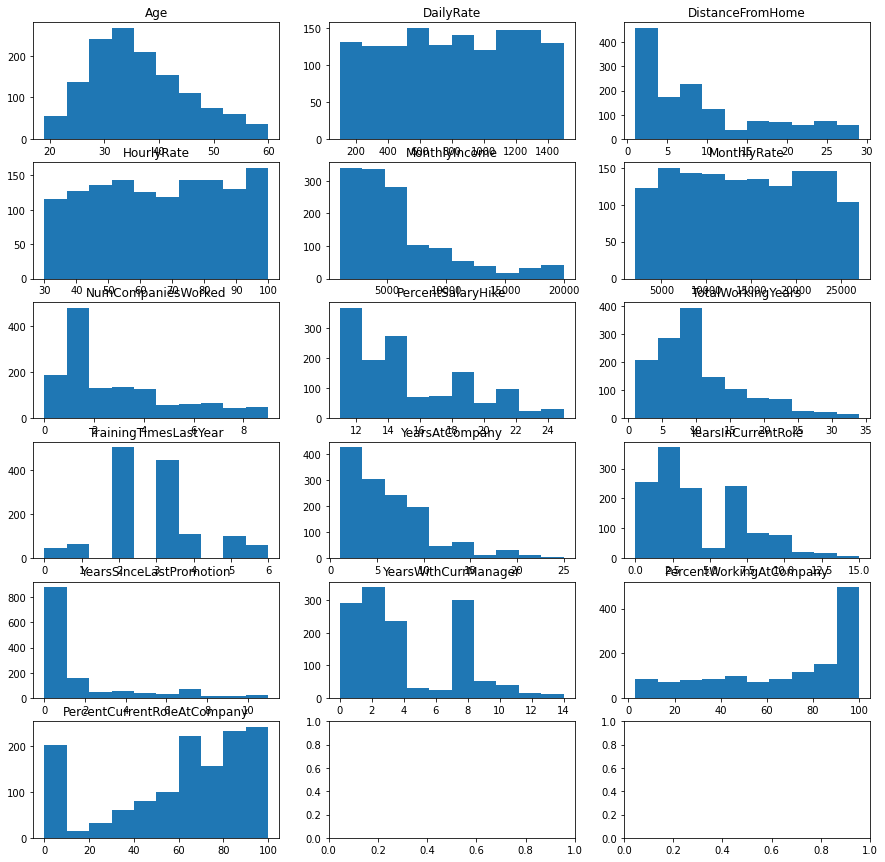

In [11]:
n_cols = 3
n_rows = int(np.ceil(len(num_fea) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
for i in range(n_rows):
  for j in range(n_cols):
    index = i * n_cols + j
    if index >= len(num_fea):
        continue
    feature = num_fea[index]
    axs[i, j].hist(df[feature])
    axs[i, j].set_title(feature)

## Categorical features

In [12]:
def normalize_discrete_values(df, feature, umbral = 0.05):
  aux = df[feature].value_counts(True).to_frame()
  aux['x'] = np.where(aux[feature] < umbral, 'Other', aux.index)
  if aux[aux['x'] == 'Other'][feature].sum() < umbral:
    aux['x'].replace({'Other' : aux.index[0]}, inplace=True)
  df[feature].replace(dict(zip(aux.index, aux.x)), inplace=True)
  return df

In [13]:
for fea in cat_fea:
  df = normalize_discrete_values(df, fea)

In [14]:
for fea in cat_fea:
  print(df[fea].value_counts(True))
  print()

Travel_Rarely        0.711095
Travel_Frequently    0.187640
Non-Travel           0.101266
Name: BusinessTravel, dtype: float64

Research & Development    0.699926
Sales                     0.300074
Name: Department, dtype: float64

3    0.414743
4    0.271780
2    0.196575
1    0.116902
Name: Education, dtype: float64

Life Sciences       0.412509
Medical             0.311988
Marketing           0.107223
Technical Degree    0.093075
Other               0.075205
Name: EducationField, dtype: float64

3    0.311243
4    0.302308
2    0.193596
1    0.192852
Name: EnvironmentSatisfaction, dtype: float64

Male      0.600149
Female    0.399851
Name: Gender, dtype: float64

3    0.589724
2    0.255398
4    0.099777
1    0.055101
Name: JobInvolvement, dtype: float64

2    0.417722
1    0.381981
3    0.144453
4    0.055845
Name: JobLevel, dtype: float64

Sales Executive              0.226359
Research Scientist           0.209233
Laboratory Technician        0.180938
Other                        

# Attribute relevance


## Continuous values to buckets

In [15]:
aux = df[num_fea].describe().T['max'] - df[num_fea].describe().T['min']
cut_features = aux[aux >= 6]
cut_features

Age                               41.000000
DailyRate                       1396.000000
DistanceFromHome                  28.000000
HourlyRate                        70.000000
MonthlyIncome                  18934.000000
MonthlyRate                    24902.000000
NumCompaniesWorked                 9.000000
PercentSalaryHike                 14.000000
TotalWorkingYears                 33.000000
TrainingTimesLastYear              6.000000
YearsAtCompany                    24.000000
YearsInCurrentRole                15.000000
YearsSinceLastPromotion           11.000000
YearsWithCurrManager              14.000000
PercentWorkingAtCompany           97.058824
PercentCurrentRoleAtCompany      100.000000
dtype: float64

In [16]:
range_to_int = dict()
int_to_range = dict()
for fea in cut_features.index:
  kb = KBinsDiscretizer(encode = 'ordinal', strategy = 'uniform')
  if cut_features[fea] < 10:
    kb.n_bins = 3
  elif cut_features[fea] < 50:
    kb.n_bins = 4
  else:
    kb.n_bins = 5
  df[fea] = kb.fit_transform(df[[fea]])
  ranges = ['%.2f|%.2f' % (a, b) for a, b in zip(kb.bin_edges_[0], kb.bin_edges_[0][1:])]
  int_to_range[fea] = dict(zip(range(len(ranges)), ranges))
  range_to_int[fea] = dict(zip(ranges, range(len(ranges))))
  df[fea].replace(int_to_range[fea], inplace=True)

## Information value & Weight of evidence

In [17]:
def get_woe_iv(df, feature, target):
  lst = []
  for val in df[feature].unique():
      lst.append({
          'Value': val,
          'All': len(df[df[feature] == val]),
          'Good': len(df[(df[feature] == val) & (df[target] == 0)]),
          'Bad': len(df[(df[feature] == val) & (df[target] == 1)])
      })
      
  dset = pd.DataFrame(lst)
  dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
  dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
  dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
  dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
  dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
  dset = dset.sort_values(by='WoE')
  
  return dset

To find that out, you will need to take a closer look at the returned data frames for those variables which have the greatest predictive power. More precisely, look at the WoE column. Ideally, you will find negative WoE score — this is the value most churners have.

In [18]:
iv_val = dict()
woe_val = dict()
for fea in cat_fea + num_fea:
  woe = get_woe_iv(df, fea, 'y')
  iv_val[fea] = woe['IV'].sum()
  woe_val[fea] = woe['WoE'].sum()
  print(fea)
  print(woe)
  print('WOE score: {:.2f}'.format(woe_val[fea]))
  print('IV score: {:.2f}'.format(iv_val[fea]))
  print()
iv_val = sorted(iv_val.items(), key=lambda item:item[1], reverse=True)

BusinessTravel
               Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE  \
1  Travel_Frequently  252   192   60    0.169912   0.281690 -0.505530   
0      Travel_Rarely  955   813  142    0.719469   0.666667  0.076223   
2         Non-Travel  136   125   11    0.110619   0.051643  0.761738   

         IV  
1  0.056507  
0  0.004025  
2  0.044924  
WOE score: 0.33
IV score: 0.11

Department
                    Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE  \
0                   Sales  403   321   82    0.284071   0.384977 -0.303959   
1  Research & Development  940   809  131    0.715929   0.615023  0.151921   

         IV  
0  0.030671  
1  0.015330  
WOE score: -0.15
IV score: 0.05

Education
   Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
1      1  157   130   27    0.115044   0.126761 -0.096983  0.001136
3      3  557   463   94    0.409735   0.441315 -0.074248  0.002345
0      2  264   224   40    0.198230   0.187793  0.054086  0.000564
2

YearsAtCompany
         Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
0    1.00|7.00  806   651  155    0.576106   0.727700 -0.233596  0.035412
1   7.00|13.00  411   363   48    0.321239   0.225352  0.354521  0.033994
3  13.00|19.00   81    74    7    0.065487   0.032864  0.689474  0.022493
2  19.00|25.00   45    42    3    0.037168   0.014085  0.970377  0.022400
WOE score: 1.78
IV score: 0.11

YearsInCurrentRole
         Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
1    0.00|3.75  760   608  152    0.538053   0.713615 -0.282386  0.049576
0    3.75|7.50  378   331   47    0.292920   0.220657  0.283290  0.020471
2   7.50|11.25  180   167   13    0.147788   0.061033  0.884364  0.076723
3  11.25|15.00   25    24    1    0.021239   0.004695  1.509373  0.024971
WOE score: 2.39
IV score: 0.17

YearsSinceLastPromotion
        Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
3  8.25|11.00    39    32    7    0.028319   0.032864 -0.148855 

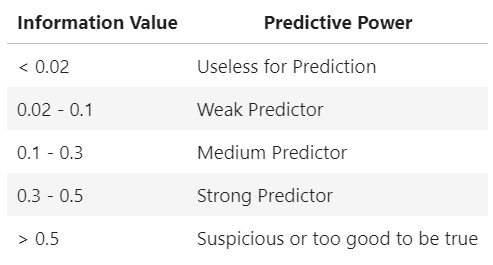

In [19]:
iv = pd.DataFrame(iv_val, columns=['Feature', 'IV'])
iv = iv[iv['IV'] > 0.1]
iv_fea = iv['Feature']
iv

,Feature,IV
0,OverTime,0.407444
1,JobLevel,0.355573
2,JobRole,0.327863
3,StockOptionLevel,0.301852
4,MonthlyIncome,0.261838
5,MaritalStatus,0.181803
6,YearsInCurrentRole,0.171742
7,TotalWorkingYears,0.167655
8,Age,0.165550
9,YearsWithCurrManager,0.141950


## Strings to numeric values

In [20]:
for fea in num_fea:
  df[fea].replace(range_to_int[fea], inplace=True)

cat_str_fea = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
df = pd.concat([df, pd.get_dummies(df[cat_str_fea], drop_first=True)], axis=1, sort=False)
reverse_onehotencoding = df[cat_str_fea].copy()
df.drop(cat_str_fea, axis=1, inplace=True)
aux = [(x.split('_')[0] in list(iv_fea)) for x in df.columns]
iv_ohe_fea = df.columns[aux]

df = df.astype(float)
df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,y,PercentWorkingAtCompany,PercentCurrentRoleAtCompany,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Sales,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Other,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,2.0,3.0,0.0,2.0,2.0,4.0,3.0,2.0,4.0,1.0,3.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,2.0,0.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,2.0,0.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,4.0,0.0,4.0,4.0,1.0,3.0,1.0,3.0,0.0,4.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,2.0,0.0,2.0,2.0,0.0,3.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,3.0,0.0,2.0,4.0,3.0,3.0,1.0,4.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Models

In [21]:
X = df[iv_ohe_fea].copy()
y = df['y'].copy()

random_state = 760110
Xt, Xv, yt, yv = train_test_split(X, y, random_state = random_state)

In [22]:
param_grid = [{
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.3, 0.5, 1, 3, 5, 7, 10],
    'max_iter': [len(Xt) * 3]
}]
gscv = GridSearchCV(
  LogisticRegression(),
  param_grid,
  scoring='roc_auc', # f1
  n_jobs=-1,
  cv=5,
)
gscv.fit(Xt, yt)
gscv.best_params_, gscv.best_score_

({'C': 0.3, 'max_iter': 3021, 'penalty': 'l2'}, 0.7581969925782872)

In [23]:
model = LogisticRegression(
  C = gscv.best_params_['C'], 
  penalty = gscv.best_params_['penalty'], 
  max_iter=len(Xt) * 3
)
model.fit(Xt, yt)
print('roc_auc_score\t', roc_auc_score(yt, model.predict_proba(Xt)[:, 1]), roc_auc_score(yv, model.predict_proba(Xv)[:, 1]))
print('accuracy\t', accuracy_score(yt, model.predict(Xt)), accuracy_score(yv, model.predict(Xv)))
print('precision\t', precision_score(yt, model.predict(Xt)), precision_score(yv, model.predict(Xv)))
print('recall\t\t', recall_score(yt, model.predict(Xt)), recall_score(yv, model.predict(Xv)))
print('f1_score\t', f1_score(yt, model.predict(Xt)), f1_score(yv, model.predict(Xv)))
print(confusion_matrix(yt, model.predict(Xt)))
print(confusion_matrix(yv, model.predict(Xv)))

roc_auc_score	 0.7970844329143744 0.8488515043675187
accuracy	 0.8599801390268124 0.8690476190476191
precision	 0.7297297297297297 0.8235294117647058
recall		 0.17088607594936708 0.2545454545454545
f1_score	 0.2769230769230769 0.38888888888888884
[[839  10]
 [131  27]]
[[278   3]
 [ 41  14]]


In [24]:
pd.DataFrame({'feature': iv_ohe_fea, 'coef': model.coef_[0]})

,feature,coef
0,Age,-0.154731
1,EnvironmentSatisfaction,-0.326437
2,JobInvolvement,-0.431525
3,JobLevel,-0.141467
4,MonthlyIncome,-0.173671
5,StockOptionLevel,-0.153249
6,TotalWorkingYears,-0.285446
7,YearsAtCompany,-0.069965
8,YearsInCurrentRole,-0.174531
9,YearsWithCurrManager,0.050298


In [25]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

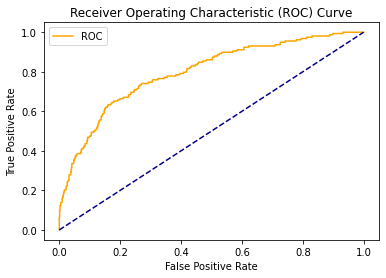

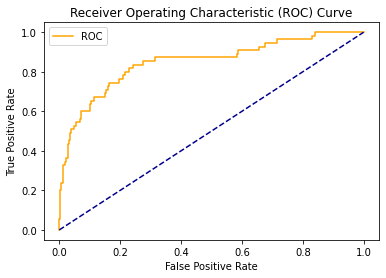

In [26]:
fpr, tpr, thresholds = roc_curve(yt, model.predict_proba(Xt)[:, 1])
plot_roc_curve(fpr, tpr)
fpr, tpr, thresholds = roc_curve(yv, model.predict_proba(Xv)[:, 1])
plot_roc_curve(fpr, tpr)

In [27]:
df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,y,PercentWorkingAtCompany,PercentCurrentRoleAtCompany,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Sales,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Other,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,2.0,3.0,0.0,2.0,2.0,4.0,3.0,2.0,4.0,1.0,3.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,2.0,0.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,2.0,0.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,4.0,0.0,4.0,4.0,1.0,3.0,1.0,3.0,0.0,4.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,2.0,0.0,2.0,2.0,0.0,3.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,3.0,0.0,2.0,4.0,3.0,3.0,1.0,4.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
for fea in range_to_int.keys():
  df[fea].replace(int_to_range[fea], inplace=True)

In [29]:
for fea in iv_ohe_fea:
  aux = df[[fea, 'y']].copy()
  aux['n'] = 1
  aux = aux.pivot_table(index = fea, columns = 'y', values = 'n', aggfunc='sum')
  aux['t'] = aux[range(2)].sum(axis=1)
  for k in range(2):
    aux[k] /= aux['t']
  print(aux)
  print()

y                 0.0       1.0    t
Age                                 
19.00|29.25  0.740132  0.259868  304
29.25|39.50  0.859504  0.140496  605
39.50|49.75  0.897351  0.102649  302
49.75|60.00  0.863636  0.136364  132

y                             0.0       1.0    t
EnvironmentSatisfaction                         
1.0                      0.737452  0.262548  259
2.0                      0.850000  0.150000  260
3.0                      0.875598  0.124402  418
4.0                      0.866995  0.133005  406

y                    0.0       1.0    t
JobInvolvement                         
1.0             0.675676  0.324324   74
2.0             0.807580  0.192420  343
3.0             0.858586  0.141414  792
4.0             0.917910  0.082090  134

y              0.0       1.0    t
JobLevel                         
1.0       0.748538  0.251462  513
2.0       0.907308  0.092692  561
3.0       0.850515  0.149485  194
4.0       0.960000  0.040000   75

y                       0.0       1.

# Scorecard

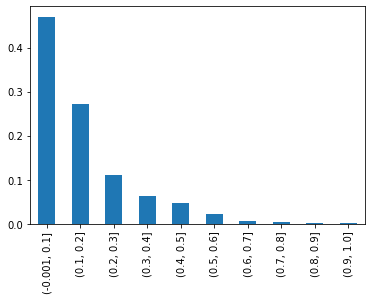

In [30]:
aux = Xt.copy()
aux['proba'] = model.predict_proba(aux)[:,1]
aux['proba'] = pd.cut(aux['proba'],include_lowest=True,bins=np.arange(0,1.1,0.1))
aux.proba.value_counts(True).sort_index().plot(kind='bar')

In [31]:
pdo = 11.5  
base_score = 326 
base_odds = 1 
factor = float(pdo) / np.log(2)
offset = base_score - factor * np.log(base_odds)

n = len(iv_ohe_fea)
betas = model.coef_[0]
alpha = model.intercept_[0]
for feat, beta in zip(iv_ohe_fea, betas):
    aux['P_' + feat] = np.ceil((-aux[feat] * beta + alpha / n) * factor + offset / n).astype(int)
aux['score'] = aux[[f for f in aux.columns if f[:2] == 'P_']].sum(axis=1)
aux.score.describe()

count    1007.000000
mean      390.581927
std        18.802706
min       321.000000
25%       379.000000
50%       390.000000
75%       403.000000
max       447.000000
Name: score, dtype: float64

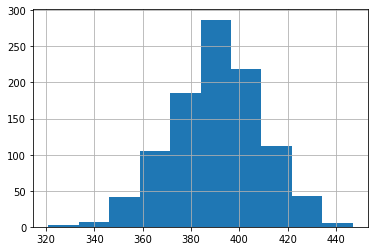

In [32]:
aux.score.hist()

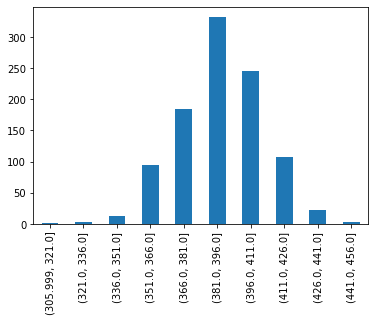

In [33]:
aux['r_score'] = pd.cut(aux.score, bins=range(min(aux.score) - 15,max(aux.score) + 15,15),include_lowest=True)
aux.r_score.value_counts().sort_index().plot(kind='bar')

In [34]:
aux['target']  = yt
aux['n']= 1.0
aux['r_score'] = aux['r_score'].astype(str)
aux['proba'] = aux['proba'].astype(str)
aux[['r_score','proba','target','n']].groupby(['r_score', 'proba', 'target']).sum()

n
r_score          proba         target       
(305.999, 321.0] (0.9, 1.0]    1.0       1.0
(321.0, 336.0]   (0.7, 0.8]    1.0       1.0
                 (0.8, 0.9]    1.0       2.0
(336.0, 351.0]   (0.5, 0.6]    1.0       3.0
                 (0.6, 0.7]    0.0       1.0
                               1.0       5.0
                 (0.7, 0.8]    1.0       4.0
(351.0, 366.0]   (0.3, 0.4]    0.0      16.0
                               1.0      11.0
                 (0.4, 0.5]    0.0      25.0
                               1.0      23.0
                 (0.5, 0.6]    0.0       9.0
                               1.0      11.0
(366.0, 381.0]   (0.1, 0.2]    0.0      31.0
                               1.0       5.0
                 (0.2, 0.3]    0.0      79.0
                               1.0      32.0
                 (0.3, 0.4]    0.0      27.0
                               1.0      10.0
(381.0, 396.0]   (-0.001, 0.1] 0.0      84.0
                               1.0      10.0
                 (0.1, 0.2]    0.0     212.0
                               1.0      26.0
(396.0, 411.0]   (-0.001, 0.1] 0.0     235.0
                               1.0      11.0
(411.0, 426.0]   (-0.001, 0.1] 0.0     104.0
                               1.0       3.0
(426.0, 441.0]   (-0.001, 0.1] 0.0      23.0
(441.0, 456.0]   (-0.001, 0.1] 0.0       3.0

In [35]:
for fea in [x for x in range_to_int.keys() if x in iv_ohe_fea]:
  aux[fea].replace(int_to_range[fea], inplace=True)

l_sc = []
for fea in iv_ohe_fea:
  aux2 = aux[[fea, 'P_%s' % fea]].copy().drop_duplicates().reset_index(drop=True)
  aux2.rename(columns={fea:'value','P_%s' % fea:'points'},inplace=True)
  aux2['feature'] = fea
  l_sc.append(aux2)

In [36]:
sc = pd.concat(l_sc,ignore_index=True)

In [37]:
sc = sc.groupby(['feature','value']).sum()

In [38]:
sc.reset_index()

,feature,value,points
0,Age,19.00|29.25,16
1,Age,29.25|39.50,18
2,Age,39.50|49.75,21
3,Age,49.75|60.00,23
4,BusinessTravel_Travel_Frequently,0,16
5,BusinessTravel_Travel_Frequently,1,2
6,BusinessTravel_Travel_Rarely,0,16
7,BusinessTravel_Travel_Rarely,1,10
8,EnvironmentSatisfaction,1,21
9,EnvironmentSatisfaction,2,27


# 2D visualization

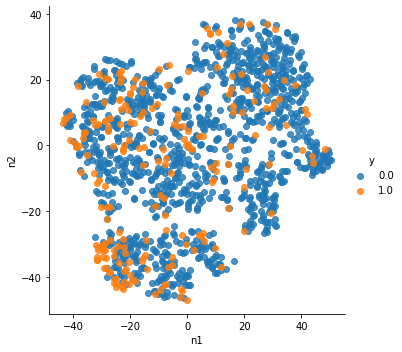

In [39]:
tsne = pd.DataFrame(TSNE(n_components=2).fit_transform(X), columns=['n1', 'n2'])
tsne['y'] = y
sns.lmplot(data=tsne, x='n1', y='n2', hue='y', fit_reg=False)

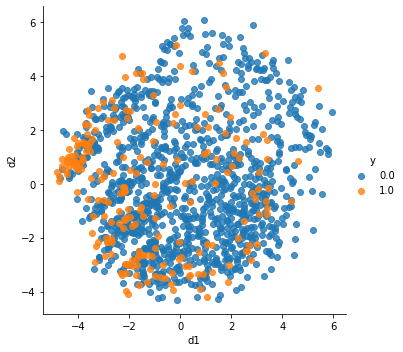

In [40]:
mds = pd.DataFrame(MDS(n_components=2).fit_transform(X), columns=['d1', 'd2'])
mds['y'] = y
sns.lmplot(data=mds, x='d1', y='d2', hue='y', fit_reg=False)

[0.18617632 0.27790742]


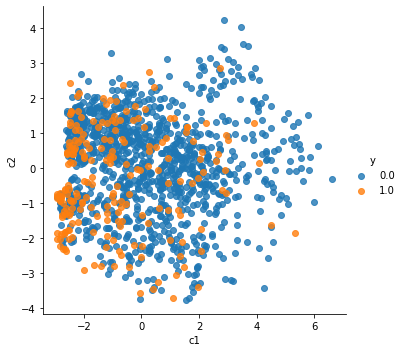

In [41]:
Xpca = StandardScaler().fit_transform(X)
pca = PCA(n_components=2).fit(Xpca)
print(pca.explained_variance_ratio_.cumsum())
pca = pd.DataFrame(pca.transform(Xpca), columns=['c1', 'c2'])
pca['y'] = y
sns.lmplot(data=pca, x='c1', y='c2', hue='y', fit_reg=False)